In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

### 1.0 Set Up Dataset

In [2]:
df = pd.read_csv('eicu_full/full_data_labelled.csv')
df.set_index('patientunitstayid', inplace=True)
df.shape

(144923, 52)

In [3]:
df.drop('hyperkalemic', axis=1, inplace=True)
df.columns

Index(['-basos', '-eos', '-lymphs', '-monos', '-polys', 'ALT (SGPT)',
       'AST (SGOT)', 'BUN', 'Base Excess', 'CPK', 'FiO2', 'HCO3', 'Hct', 'Hgb',
       'MCH', 'MCHC', 'MCV', 'MPV', 'O2 Sat (%)', 'PT', 'PT - INR', 'PTT',
       'RBC', 'RDW', 'TSH', 'WBC x 1000', 'albumin', 'alkaline phos.',
       'anion gap', 'bedside glucose', 'bicarbonate', 'calcium', 'chloride',
       'creatinine', 'glucose', 'ionized calcium', 'lactate', 'magnesium',
       'pH', 'paCO2', 'paO2', 'phosphate', 'platelets x 1000', 'potassium',
       'sodium', 'total bilirubin', 'total protein', 'triglycerides',
       'troponin - I', 'urinary specific gravity', 'falsepositive'],
      dtype='object')

In [4]:
df.fillna(df.median(), inplace=True)

#### 1.1 Split Into Training, Validation, and Test Sets

In [5]:
train, validate, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])
train.shape

(86953, 51)

In [6]:
validate.shape

(28985, 51)

In [7]:
test.shape

(28985, 51)

In [8]:
def split_xy(data, ylabel):
    return data.drop(ylabel, axis=1), data[ylabel]

x_train, y_train = split_xy(train, 'falsepositive')
x_val, y_val = split_xy(validate, 'falsepositive')
x_test, y_test = split_xy(test, 'falsepositive')

### 2.0 Create Initial Model

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

In [10]:
%%time
rf = RandomForestRegressor(n_estimators=200, random_state=0, oob_score=True, n_jobs=-1)
rf.fit(x_train, y_train)

Wall time: 18.2 s


RandomForestRegressor(n_estimators=200, n_jobs=-1, oob_score=True,
                      random_state=0)

In [11]:
preds = rf.predict(x_val)
preds

array([0.08, 0.  , 0.  , ..., 0.  , 0.21, 0.  ])

#### 2.1 Get Metrics

In [12]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [13]:
accuracy_score(y_val, (preds > 0.5))

0.9461100569259963

In [14]:
f1_score(y_val, (preds > 0.5))

0.3045414069456812

In [15]:
precision_score(y_val, (preds > 0.5))

0.6074600355239786

In [16]:
recall_score(y_val, (preds > 0.5))

0.20320855614973263

In [17]:
rf.oob_score_

0.2881358291780267

#### 2.1.1 Investigate Classification Threshold

C:\Projects\bwest\venv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


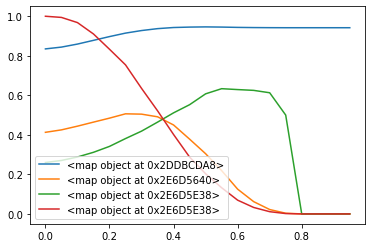

In [18]:
metrics = [accuracy_score, f1_score, precision_score, recall_score]
for metric in metrics:
    vals = []
    for thresh in range(0, 100, 5):
        vals.append(metric(y_val, (preds > thresh/100.0)))
    sns.lineplot(np.arange(0, 1, 0.05), vals, label=map(lambda x: x._str__(), metrics))

#### 2.2 Using Classifier Instead

In [19]:
%%time
rfc = RandomForestClassifier(n_estimators=200, random_state=0, oob_score=True, n_jobs=-1)
rfc.fit(x_train, y_train)

Wall time: 7.52 s


RandomForestClassifier(n_estimators=200, n_jobs=-1, oob_score=True,
                       random_state=0)

In [20]:
cpreds = rfc.predict(x_val)

accuracy_score(cpreds, y_val), f1_score(cpreds, y_val), precision_score(cpreds, y_val), recall_score(cpreds, y_val), rfc.oob_score_

(0.9439710194928411,
 0.1568016614745587,
 0.08972073677956031,
 0.6213991769547325,
 0.9443377456787)

### 3.0 Model Improvements

#### 3.1 Feature Importance

<AxesSubplot:ylabel='cols'>

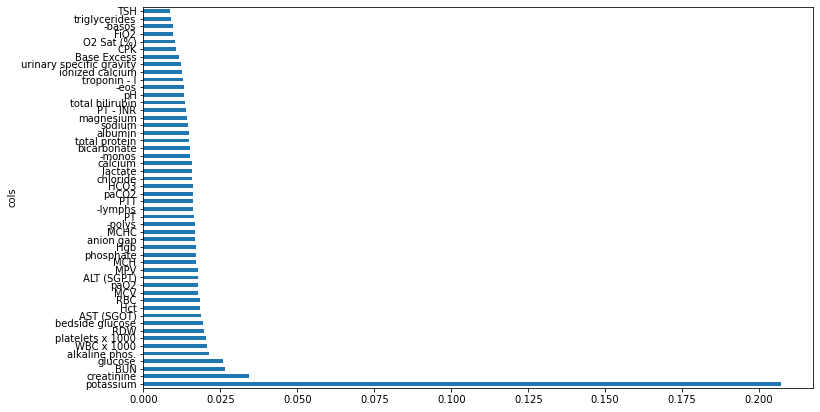

In [21]:
imps = pd.DataFrame({'cols':x_train.columns, 'imp':rfc.feature_importances_}).sort_values('imp', ascending=False)

imps.plot('cols', 'imp', 'barh', figsize=(12, 7), legend=False)

In [22]:
to_keep = (imps[imps.imp > 0.02].cols).append(pd.Series('falsepositive'))
len(to_keep)

8

In [23]:
df_keep = df[to_keep].copy()
df_keep.shape

(144923, 8)

In [24]:
train_fi, validate_fi, test_fi = np.split(df_keep.sample(frac=1), [int(0.6*len(df_keep)), int(0.8*len(df_keep))])
train_fi.shape

(86953, 8)

In [25]:
def split_xy(data, ylabel):
    return data.drop(ylabel, axis=1), data[ylabel]

x_train_fi, y_train_fi = split_xy(train_fi, 'falsepositive')
x_val_fi, y_val_fi = split_xy(validate_fi, 'falsepositive')
x_test_fi, y_test_fi = split_xy(test_fi, 'falsepositive')

In [26]:
%%time
rf_fi = RandomForestClassifier(n_estimators=100, random_state=0, oob_score=True, n_jobs=-1)
rf_fi.fit(x_train_fi, y_train_fi)

fi_preds = rf_fi.predict(x_val_fi)
accuracy_score(fi_preds, y_val_fi), f1_score(fi_preds, y_val_fi), precision_score(fi_preds, y_val_fi), recall_score(fi_preds, y_val_fi), rf_fi.oob_score_

Wall time: 1.45 s


(0.9419354838709677,
 0.22549470777726643,
 0.14394829612220916,
 0.5201698513800425,
 0.9413706255103331)

<AxesSubplot:ylabel='cols'>

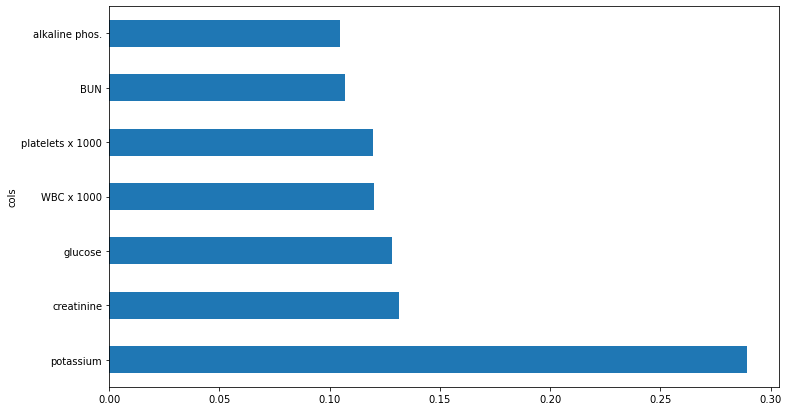

In [27]:
imps_fi = pd.DataFrame({'cols':x_train_fi.columns, 'imp':rf_fi.feature_importances_}).sort_values('imp', ascending=False)
imps_fi.plot('cols', 'imp', 'barh', figsize=(12, 7), legend=False)

#### 3.2 n_estimators

In [28]:
%%time
rf_nest = RandomForestClassifier(n_estimators=50, random_state=0, oob_score=True, n_jobs=-1)
rf_nest.fit(x_train, y_train)

Wall time: 2.01 s


RandomForestClassifier(n_estimators=50, n_jobs=-1, oob_score=True,
                       random_state=0)

In [29]:
preds_nest = rf_nest.predict(x_val)

accuracy_score(preds_nest, y_val), f1_score(preds_nest, y_val), precision_score(preds_nest, y_val), recall_score(preds_nest, y_val), rfc.oob_score_

(0.9442815249266863,
 0.1739130434782609,
 0.10101010101010101,
 0.625,
 0.9443377456787)

In [30]:
%%time
rf_nest = RandomForestClassifier(n_estimators=200, random_state=0, oob_score=True, n_jobs=-1)
rf_nest.fit(x_train, y_train)
preds_nest = rf_nest.predict(x_val)

accuracy_score(preds_nest, y_val), f1_score(preds_nest, y_val), precision_score(preds_nest, y_val), recall_score(preds_nest, y_val), rfc.oob_score_

Wall time: 7.49 s


(0.9439710194928411,
 0.1568016614745587,
 0.08972073677956031,
 0.6213991769547325,
 0.9443377456787)

#### 3.3 min_samples_leaf

In [31]:
%%time
rf_msl = RandomForestClassifier(n_estimators=200, min_samples_leaf=3, random_state=0, oob_score=True, n_jobs=-1)
rf_msl.fit(x_train, y_train)
preds_msl = rf_msl.predict(x_val)

accuracy_score(preds_msl, y_val), f1_score(preds_msl, y_val), precision_score(preds_msl, y_val), recall_score(preds_msl, y_val), rfc.oob_score_

Wall time: 7.14 s


(0.9438330170777989,
 0.12941176470588234,
 0.0718954248366013,
 0.6470588235294118,
 0.9443377456787)

In [32]:
%%time
rf_msl = RandomForestClassifier(n_estimators=200, min_samples_leaf=5, random_state=0, oob_score=True, n_jobs=-1)
rf_msl.fit(x_train, y_train)
preds_msl = rf_msl.predict(x_val)

accuracy_score(preds_msl, y_val), f1_score(preds_msl, y_val), precision_score(preds_msl, y_val), recall_score(preds_msl, y_val), rfc.oob_score_

Wall time: 7.01 s


(0.9441090219078834,
 0.11860718171926006,
 0.0647653000594177,
 0.7032258064516129,
 0.9443377456787)

In [33]:
%%time
rf_msl = RandomForestClassifier(n_estimators=100, min_samples_leaf=3, random_state=0, oob_score=True, max_features=0.9, n_jobs=-1)
rf_msl.fit(x_train, y_train)
preds_msl = rf_msl.predict(x_val)

accuracy_score(preds_msl, y_val), f1_score(preds_msl, y_val), precision_score(preds_msl, y_val), recall_score(preds_msl, y_val), rfc.oob_score_

Wall time: 8.54 s


(0.9455925478695877,
 0.2962962962962963,
 0.19726678550207963,
 0.5949820788530465,
 0.9443377456787)

#### 3.4 max_features

In [34]:
%%time
rf_mf = RandomForestClassifier(n_estimators=200, random_state=0, max_features=0.9, oob_score=True, n_jobs=-1)
rf_mf.fit(x_train, y_train)
preds_mf = rf_mf.predict(x_val)

accuracy_score(preds_mf, y_val), f1_score(preds_mf, y_val), precision_score(preds_mf, y_val), recall_score(preds_mf, y_val), rfc.oob_score_

Wall time: 18.1 s


(0.9461790581335173,
 0.3109540636042403,
 0.20915032679738563,
 0.6058519793459552,
 0.9443377456787)

In [35]:
%%time
rf_mf = RandomForestClassifier(n_estimators=200, random_state=0, max_features=0.8, oob_score=True, n_jobs=-1)
rf_mf.fit(x_train, y_train)
preds_mf = rf_mf.predict(x_val)

accuracy_score(preds_mf, y_val), f1_score(preds_mf, y_val), precision_score(preds_mf, y_val), recall_score(preds_mf, y_val), rfc.oob_score_

Wall time: 1min 57s


(0.9459030533034328,
 0.29874776386404295,
 0.1984551396316102,
 0.6039783001808319,
 0.9443377456787)

In [36]:
%%time
rf_mf = RandomForestClassifier(n_estimators=200, random_state=0, max_features=0.5, oob_score=True, n_jobs=-1)
rf_mf.fit(x_train, y_train)
preds_mf = rf_mf.predict(x_val)

accuracy_score(preds_mf, y_val), f1_score(preds_mf, y_val), precision_score(preds_mf, y_val), recall_score(preds_mf, y_val), rfc.oob_score_

Wall time: 12.6 s


(0.9455925478695877,
 0.27892089620484684,
 0.18122400475341652,
 0.6051587301587301,
 0.9443377456787)

In [37]:
%%time
rf_mf = RandomForestClassifier(n_estimators=200, random_state=0, max_features='sqrt', oob_score=True, n_jobs=-1)
rf_mf.fit(x_train, y_train)
preds_mf = rf_mf.predict(x_val)

accuracy_score(preds_mf, y_val), f1_score(preds_mf, y_val), precision_score(preds_mf, y_val), recall_score(preds_mf, y_val), rfc.oob_score_

Wall time: 7.46 s


(0.9439710194928411,
 0.1568016614745587,
 0.08972073677956031,
 0.6213991769547325,
 0.9443377456787)

In [38]:
%%time
rf_mf = RandomForestClassifier(n_estimators=200, random_state=0, max_features='log2', oob_score=True, n_jobs=-1)
rf_mf.fit(x_train, y_train)
preds_mf = rf_mf.predict(x_val)

accuracy_score(preds_mf, y_val), f1_score(preds_mf, y_val), precision_score(preds_mf, y_val), recall_score(preds_mf, y_val), rfc.oob_score_

Wall time: 6.79 s


(0.9433155080213904,
 0.07644744238336144,
 0.04040404040404041,
 0.7083333333333334,
 0.9443377456787)

#### 4.0 Testing Time

In [39]:
%%time
rf_mf = RandomForestClassifier(n_estimators=200, random_state=0, max_features=0.9, oob_score=True, n_jobs=-1)
rf_mf.fit(x_train, y_train)
preds_mf = rf_mf.predict(x_test)

accuracy_score(preds_mf, y_test), f1_score(preds_mf, y_test), precision_score(preds_mf, y_test), recall_score(preds_mf, y_test), rfc.oob_score_

Wall time: 18.7 s


(0.9464895635673625,
 0.30229419703103916,
 0.20204449789536982,
 0.6,
 0.9443377456787)

In [40]:
%%time
rf_mf = RandomForestClassifier(n_estimators=200, random_state=0, max_features=0.9, oob_score=True, n_jobs=-1, min_samples_leaf=3)
rf_mf.fit(x_train, y_train)
preds_mf = rf_mf.predict(x_test)

accuracy_score(preds_mf, y_test), f1_score(preds_mf, y_test), precision_score(preds_mf, y_test), recall_score(preds_mf, y_test), rfc.oob_score_

Wall time: 16.4 s


(0.9462135587372779,
 0.287151348879744,
 0.1888153938665063,
 0.5992366412213741,
 0.9443377456787)

In [41]:
%%time
rf_mf = RandomForestRegressor(n_estimators=200, random_state=0, max_features=0.9, oob_score=True, n_jobs=-1, min_samples_leaf=3)
rf_mf.fit(x_train, y_train)
preds_mf = rf_mf.predict(x_test)

accuracy_score((preds_mf>0.3), y_test), f1_score((preds_mf>0.3), y_test), precision_score((preds_mf>0.3), y_test), recall_score((preds_mf>0.3), y_test), rfc.oob_score_

Wall time: 14.8 s


(0.9302742797998965,
 0.5102980373152411,
 0.6331930246542393,
 0.4273538961038961,
 0.9443377456787)